In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 200,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8580246913580247, Loss: 0.5684146174678096
Checkpoint 20, Accuracy: 0.9320987654320988, Loss: 0.40629249148898655
Checkpoint 30, Accuracy: 0.9012345679012346, Loss: 0.4192594598840784
Checkpoint 40, Accuracy: 0.9197530864197531, Loss: 0.3911466598510742
Checkpoint 50, Accuracy: 0.9382716049382716, Loss: 0.2848505973815918
Checkpoint 60, Accuracy: 0.9197530864197531, Loss: 0.290302453217683
Checkpoint 70, Accuracy: 0.9382716049382716, Loss: 0.27193194848519786
Checkpoint 80, Accuracy: 0.9629629629629629, Loss: 0.2224623715436017
Checkpoint 90, Accuracy: 0.9629629629629629, Loss: 0.19426580711647315
Checkpoint 100, Accuracy: 0.9753086419753086, Loss: 0.17260076381542064
Checkpoint 110, Accuracy: 0.9629629629629629, Loss: 0.1626742680867513
Checkpoint 120, Accuracy: 0.9691358024691358, Loss: 0.13861721533316154
Checkpoint 130, Accuracy: 0.9753086419753086, Loss: 0.1247018266607214
Checkpoint 140, Accuracy: 0.9691358024691358, Loss: 0.13581314793339483
Checkpoint

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [3.6624461e-01 6.3348335e-01 2.7203871e-04]
[0. 1. 0.] <-> [1.2745319e-03 9.9867165e-01 5.3844804e-05]
[0. 1. 0.] <-> [8.9912377e-03 9.9098879e-01 2.0007517e-05]
[1. 0. 0.] <-> [0.66701216 0.33173576 0.00125201]
[1. 0. 0.] <-> [0.99634403 0.00223672 0.00141922]
[1. 0. 0.] <-> [0.99357504 0.00215264 0.00427236]
[1. 0. 0.] <-> [0.9400963  0.0399541  0.01994964]
[0. 1. 0.] <-> [1.0817524e-02 9.8916441e-01 1.8035060e-05]
[1. 0. 0.] <-> [0.9950399  0.00232578 0.00263439]
[1. 0. 0.] <-> [0.98804665 0.00941994 0.00253343]
[1. 0. 0.] <-> [0.99534744 0.00260155 0.00205109]
[1. 0. 0.] <-> [0.99696916 0.00136422 0.00166666]
[1. 0. 0.] <-> [0.99515164 0.00104383 0.00380454]
[1. 0. 0.] <-> [0.99361306 0.00376764 0.00261941]
[1. 0. 0.] <-> [3.8296121e-01 6.1673445e-01 3.0427132e-04]
[1. 0. 0.] <-> [0.9919081  0.00343335 0.00465857]
[0. 0. 1.] <-> [4.4781482e-03 1.9445067e-04 9.9532735e-01]
[1. 0. 0.] <-> [0.98858136 0.0046861  0.00673257]
[1. 0. 0.] <-> [1.8853728e-01 8.1126672e-01 1.

In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

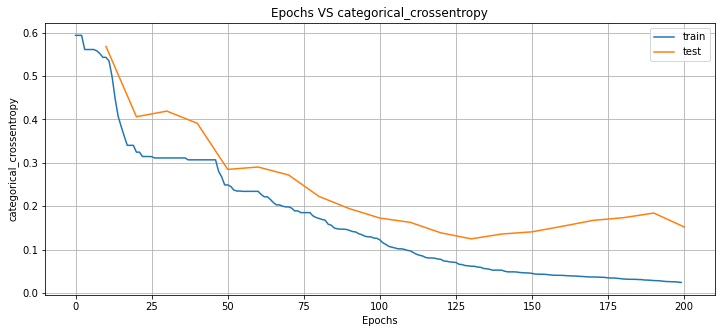

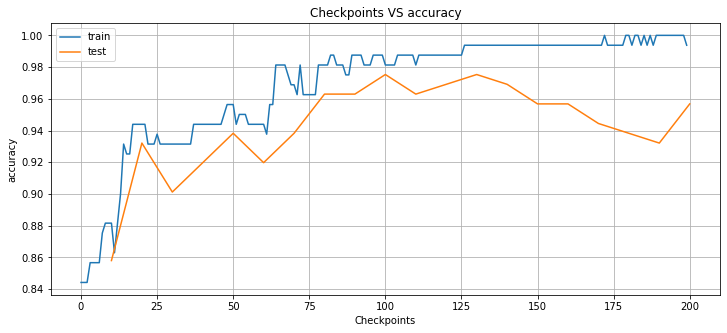

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8580246913580247, 'mean_square_error': 0.3079524828293775, 'categorical_crossentropy': 0.5684146174678096, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 17, 'tn_hit': 13, 'fn_hit': 0}, 1: {'tp_hit': 2, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 14}, 2: {'tp_hit': 5, 'fp_hit': 6, 'tn_hit': 88, 'fn_hit': 9}}, 'checkpoint': 10} 


{'accuracy': 0.9320987654320988, 'mean_square_error': 0.1992574864026174, 'categorical_crossentropy': 0.40629249148898655, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 6, 'tn_hit': 24, 'fn_hit': 4}, 1: {'tp_hit': 13, 'fp_hit': 4, 'tn_hit': 88, 'fn_hit': 3}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 4}}, 'checkpoint': 20} 


{'accuracy': 0.9012345679012346, 'mean_square_error': 0.22664794179290626, 'categorical_crossentropy': 0.4192594598840784, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 14, 'tn_hit': 16, 'fn_hit': 2}, 1: {'tp_hit': 12, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 4}, 2: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 94, 'fn_h

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-1.3961018   2.430519    3.          0.08112637  0.4741967 ]
 bias: -1.0415276288986206

Neuron 1: weights:
[ 0.09151734 -3.         -0.3076037   0.5499427   3.        ]
 bias: -3.0

Neuron 2: weights:
[ 0.3800778  1.370679  -1.8814656 -2.7159457 -2.835778 ]
 bias: 0.436615526676178

Neuron 3: weights:
[-2.255084   3.         3.         0.8293646 -2.060702 ]
 bias: -3.0

$
Layer 2
Neuron 0: weights:
[-1.909523 -3.        3.       -3.      ]
 bias: 1.6564557552337646

Neuron 1: weights:
[ 3.        -3.        -0.9784711  3.       ]
 bias: -1.4810688495635986

Neuron 2: weights:
[-3.         3.        -3.        -2.8071747]
 bias: 1.061098575592041

$

